# Сборный проект: выявление закономерностей определяющих успешность игры


Исходный датафрем, на основе которого будут сделаны выводы в данной работе - файл, в котором содержится информация об играх за разные годы. Данные содержат характеристики игры, важные для выявления закономерностей, которые определяют, будет ли игра популярна у пользователей и принесет ли она доход разработчикам. <br/>
В ходе работы будут проанализированы все факторы, сделаны выводы и проверены несколько гипотез. Так же будут выявлены особенности разных регионов. <br/><br/>
Действовать будем по такому плану:
* загрузка и первичный осмотр имеющегося датафрема
* подготовка данных для кпрощения дальнейшего анализа(преобразование типов, названий и удаление дубликатов)
* исследовательский анализ данных и визуализация информации
* выявление актуального периода, за который лучше анализировать игры, чтобы получить актуальную информацию на будущий год
* составление статистики по самым популярным платформам, жанрам и тд.
* составление портрета пользователя по региону(предпочтения)
* проверка гипотез

In [1]:
import pandas as pd
import warnings
warnings.simplefilter("ignore") 
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy import stats as st
from scipy.stats import binom


### Шаг.  Загрузка данных

In [2]:
data =  pd.read_csv('/datasets/games.csv')
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Мы считали файл с исходными данными и вывели первые 10 строк. В файле довольно подробно описывается каждая игра, но видны некоторые недочеты. Что сразу бросается в глаза? <br/>
* названия столбцов записаны не по правилам, названия должны быть все в нижнем регистре
* замечено довольно много значений NaN, даже в первых 10 строках, надо их обработать
* переменная отвечающая за год выпуска записана с плавающей точкой, это нелогично
<br/><br/>
Так же проверим информацию о датафреме в целом, про количество строк, количество пропусков и пр.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В датафрейме около 16.7 тыс. строк. В основных данных пропусков довольно мало, и довольно много пропусков встречается в столбцах с рейтингом. Позже посмотрим, так ли они важны и если важны, то как их можно обработать.


### Шаг. Предобработка данных
#### Преобразование названий столбцов

In [4]:
# переиминуем названия колонок, чтобы привести все символы к нижнему регистру.
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

#### Изменение типов данных
Изменим тип данных в некоторых столбцах для более удобной работы. <br/><br/>
Замену типа решено было провести в столбце с годом выпуска, так как год это точно целое число <br/>
В столбце с оценкой критиков было решено привести 100 бальную шкалу к 10 бальной, для более удобного оценивания, сохранив дробную часть.
<br/>
Так же необычный тип данных для чисел - object встречается в столбце user_score, но просто изменить его на float мы пока что не можем, так как там действительно встречаются нечисловые значения, которые мы обработаем позже.


In [5]:
data['year_of_release'] = data['year_of_release'].astype('Int64', errors = 'ignore')
data['critic_score'] = data['critic_score']/10


#### Проверка наличия явных дубликатов

In [6]:
#проверим наличие явных дубликатов 
data.duplicated().sum()

0

**Проверка наличия неявных дубликатов** <br/>
Неявными дубликатами могут являться строки, которые описывают одну и ту же игру несколько раз. Будем искать так: проверим есть ли совпадения сразу по 3 столбцам(имя, платформа и год релиза)

In [7]:
#для начала посмотрим еще раз информацию о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.4+ MB


In [8]:
# создадим список с колонками, в которых будем искать дубликаты
columns_to_check = ['name', 'year_of_release', 'platform']

# Проверяем наличие дубликатов в указанных столбцах
duplicates = data.duplicated(subset=columns_to_check, keep=False)

# Выводим строки с дубликатами на экран
print("Строки с дубликатами:")
print(data[duplicates])

Строки с дубликатами:
                name platform  year_of_release   genre  na_sales  eu_sales  \
604    Madden NFL 13      PS3             2012  Sports      2.11      0.22   
659              NaN      GEN             1993     NaN      1.78      0.53   
14244            NaN      GEN             1993     NaN      0.00      0.00   
16230  Madden NFL 13      PS3             2012  Sports      0.00      0.01   

       jp_sales  other_sales  critic_score user_score rating  
604        0.00         0.23           8.3        5.5      E  
659        0.00         0.08           NaN        NaN    NaN  
14244      0.03         0.00           NaN        NaN    NaN  
16230      0.00         0.00           8.3        5.5      E  


Мы нашли 2 строки, которые повторялись в нужных нам колонках, но они включают в себя разные данные о продажах, и это явно ошибка. Один дубликат вообще с пропуском в колонке с именем, поэтому его мы можем удалить полностью(сейчас удалим только дубликат, а ниже удалится как значение NaN). Значит мы теряем из данных всего одну строку. Это не критично.

In [9]:
# Удаляем дубликаты из DataFrame
data.drop_duplicates(subset=columns_to_check, keep='first', inplace=True)
print("\nИнформация о DataFrame после удаления дубликатов:")
print(data.info())


Информация о DataFrame после удаления дубликатов:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16712 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       10013 non-null  object 
 10  rating           9948 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.5+ MB
None


#### Обработка пропусков

In [10]:
#еще раз выведем количество пропусков
data.isna().sum()

name                  1
platform              0
year_of_release     269
genre                 1
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8577
user_score         6700
rating             6765
dtype: int64

В столбце с годом релиза количество пропусков составляет 1.6% от общего датафрейма. Я думаю можно их удалить, так как данные восстановить будет проблематично и долго, а нам важен год выпуска игры. <br/>
Также есть по 2 пропуска в столбцах с жанром и названием. Тут количество довольно незначительно и данные не восстановить, тоже почистим пропуски.<br/><br/>
Судя по тому, как мало пропусков в столбце с годами релиза по сравнению с тем, что во всех остальных столбцах все данные заполнены, можно сделать вывод что такое допущено случайно, либо за ненадобностью(так как год встречается в названии игры)

In [11]:
data = data.dropna(subset = ['year_of_release','name','genre'])
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating             6676
dtype: int64

Так же в данных user_score стоит тип данных object, а это значит что там встречаются не только численные значения. Помимо того там есть аббревеатура 'tbd', которая расшифровывается как 'to be determinated' - будет определено/уточняется. Мы это можем спокойно приравнять к пропущенному значению NaN.

In [12]:
#найдем все строки со значением tbd в user_score и приравняем их к NaN
data.loc[data['user_score'] == 'tbd','user_score'] = float('nan')
#заменим тип данных во всем столбце на float
data['user_score'] = data['user_score'].astype('float64', errors = 'ignore')
#проверим количество строк с tbd
data.loc[data['user_score'] == 'tbd']['user_score'].count()

0

Остались столбцы с оценками. Пропуски тут не получится заполнить никак, так как пользователи и критики по разному оценивают игры, и нельзя угадать, что на этот раз может понравится и не понравится обеим категориям. Поэтому пропуски оставляем

In [13]:
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating             6676
dtype: int64

С пропусками в столбце рейтинг мы пока ничего сделать не можем, потому что это рейтинг который обозначает возрастное ограничение. Пока что оставим все так как есть. <br/>
Общее количество пропусков получилось почти треть датафрейма. Удалять их будет сильной потерей для данных.<br/>
Конечно мы бы могли заполнить пропуски медианными значениями по жанру и(или) году выпуска, но думаю что это не будет иметь смысл так как никогда не угадаешь что может повлиять на оценку игры, это может оценить только человек.<br/><br/>
**Возможные причины оставшихся пропусков:**
1. В столбцах с оценками пользователей и критиков пропуски могли появиться по причине того, что игра не достаточно популярна, для того чтобы ее оценило официально много человек и оставило отзывы. Она могла быть выложена там, где нет возможности оставить отзыв, либо же эта опция необязательна и пользователи просто пропустили ее из-за нежелания писать отзыв. Не все игры проходят через критиков, все таки почти любое исследование надо спонсировать, а если игра непопулярна, то конечно этого не было сделано. Ну и всегда можно сослаться на обычный технический сбой, что данные об оценках потерялись при парсинге, либо если таблицу данные вручную - обычный человеческий фактор.
2. Пропуски в столбце с рейтингом ESRB могли возникнуть потому, что их присваивает негосударственная огранизация, которая преимущественно оценивает игры США и Канады. Она могла либо просто не успеть присвоить оценки каким-то играм, которые не так популярны, либо же у нас есть регион Япония, а так как стандарты американские, в Японии может идти оценка по другим стандартам и от других организаций. Ну либо же причиной мог стать обычный технический сбой или человеческий фактор.

#### Проверка значений на логичность
У нас есть столбцы, которые ограничены логически. Рейтинг выставляется по 10 бальной(либо 100 бальной шкале). Проверим, встречаются ли в датфрейме значения, которые не удовлетворяют условиям логически.



In [14]:
data.query('critic_score > 10  or user_score > 10')['name'].count()

0

Все значения рейтинга входят в промежуток от 0 до 10, значит все правильно, можно двигаться дальше.

#### Создание столбца с суммарным колличеством продаж по всем регионам


In [15]:
data['sales'] = data['na_sales']+data['eu_sales'] + data['jp_sales'] + data['other_sales']
#убедимся, что все выглядит корректно
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,7.6,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,8.2,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,8.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


**Вывод по предобработке данных:** мы закончили обработку данных и вот какая работа была проделана:
- названия столбцов были приведены к удобному в работе нижнему регистру
- типы данных в некоторых столбцах были изменены на более подходящие
- устранены дубликаты. Явных не обнаружилось, а неявных было всего 2.
- обработаны пропуски. В важных столбцах их было несколько, такие строки были удалены, это не повлияет на исследование. А во сторостепенных столбцах(оценки и рейтинг) пропусков было много, но их никак не обработать. 
- в столбце рейтинг встречались значения "tbd", они были заменены на NaN
- значения были проверены на логичность(чтобы оценки не выходили за 10 или 100 бальную шкалу)
- был создан дополнительный столбец с расчетом общих продаж по всем регионам.

In [16]:
# Комментарий ревьюера
# Посмотрим, что осталось
temp = data.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().mean()*100,2),'%') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           9767 non-null   object 
 11  sales            16443 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.6+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
n

### Шаг. Исследовательский анализ данных

#### Статистика по количеству игр за каждый год

In [17]:
#посчитаем сколько игр выходило в каждый из годов
data.groupby('year_of_release')['name'].count()

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     652
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64

Для наглядности выведем еще и график.

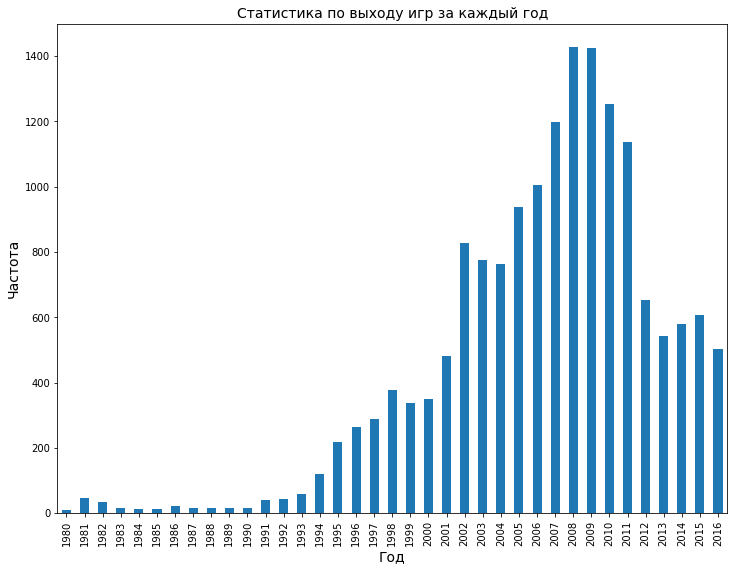

In [18]:
data.groupby('year_of_release')['name'].count().plot(kind = 'bar', figsize = (12,9))
plt.title('Статистика по выходу игр за каждый год', fontsize = 14)
plt.xlabel('Год',fontsize = 14)
plt.ylabel('Частота',fontsize = 14)
plt.show()

На графике видно, что до 2001 года выходило довольно мало игр. Самый пик пришелся на 2007-2011 годы. Учитывая то, что технологии развиваются, думаю, что нам стоит для актуальности рассматривать игры примерно за последние 10 лет. 

#### Как менялись продажи по платформам


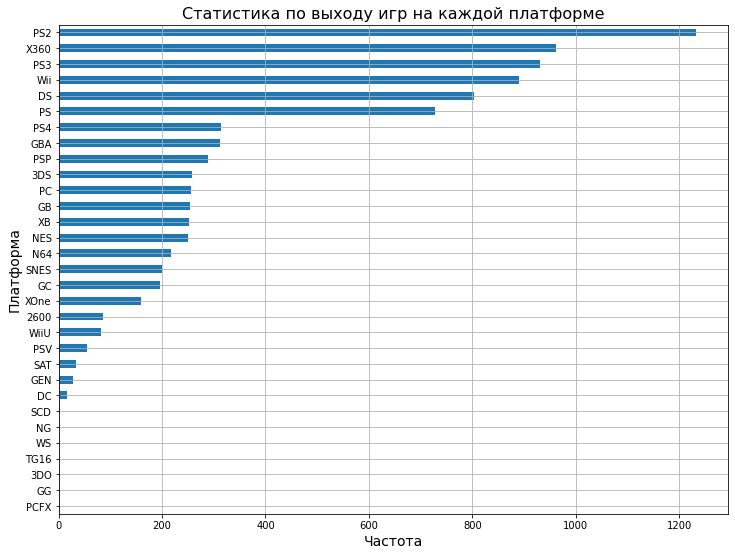

In [19]:
data.groupby(['platform'])['sales'].sum().sort_values(ascending = True).plot(kind = 'barh', figsize = (12,9), grid = True, width = 0.5)
plt.title('Статистика по выходу игр на каждой платформе', fontsize = 16)
plt.ylabel('Платформа',fontsize = 14)
plt.xlabel('Частота',fontsize = 14)
plt.show()

По графику видно, что явно выделяются из всех остальных платформ - 6. Ниже мы будем рассматривать те платформы, у которых показатель частоты больше 600.

In [20]:
#вынесем отдельно данные про все самые популярные платформы
most_popular = data.query('platform in ["PS2","X360","PS3","Wii","DS","PS"]')
data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,7.6,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,8.2,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,8.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


In [21]:
# Комментарий ревьюера
temp = data.copy() 
list(temp.groupby('platform')['sales'].sum().sort_values(ascending=False).index[:6])

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

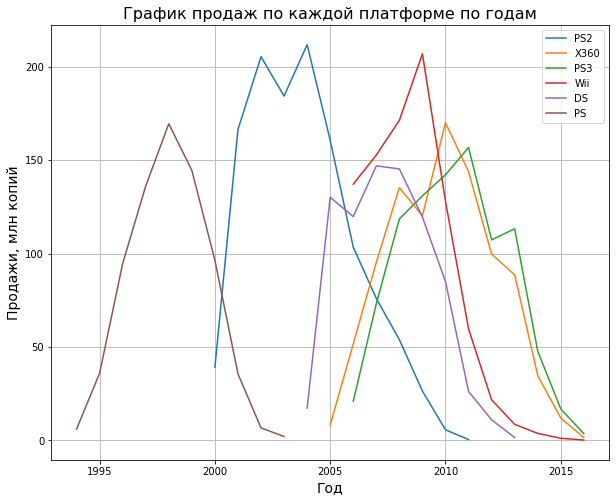

In [22]:
#после вывода графика было замечен выброс в виде строки с игрой, которая вышла в 1985 году на платформе DS. Она была 1 и это явно ошибка, так как DS существует с 2004 года. Сделаем проверку и удалим эту строку
data = data.drop(data.loc[((data['platform'] == 'DS') &(data['year_of_release'] < 2004))].index)
most_popular1 = ['PS2','X360','PS3','Wii','DS','PS']
fig, ax = plt.subplots(figsize = (10,8))

for platform in most_popular1:
    df = data[data['platform'] == platform].pivot_table(index = 'year_of_release',
                                                        values = 'sales',
                                                        aggfunc = 'sum')
    ax.plot(df.index, df['sales'], label = platform)

ax.grid(True)    
ax.legend()
plt.title('График продаж по каждой платформе по годам',fontsize = 16)
plt.xlabel('Год',fontsize = 14)
plt.ylabel('Продажи, млн копий',fontsize = 14)
plt.show()


После вывода графика было замечен выброс в виде строки с игрой, которая вышла в 1985 году на платформе DS. Она была 1 и это явно ошибка, так как DS существует с 2004 года. Сделаем проверку и удалим эту строку перед выводом графика.<br/><br/>
Также нужно было вывести характерный срок за который появляются и исчезают платформы. По графику видно, что этот срок в среднем составляет у всех 10 лет.

In [23]:
# Комментарий ревьюера
temp = data.copy() 
time_life = temp.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']).reset_index()
time_life['life'] = time_life['max'] - time_life['min'] + 1 # в срок жизни платформы, должны входить границы диапазона, 
                                                            # поэтому +1
time_life['life'].median()

7.0

#### Определяем актуальный период
Сфера видеоигр эта та сфера, которая очень быстро развивается, и для того чтобы заинтересовать пользователя важно владеть самыми актуальными данными. Поэтому предлагаю взять актуальный период как можно меньше, чтобы данные были как можно новее. <br/> 
Думаю, учитывать будем 2013 - 2016 год.

In [24]:
#сделаем срез и отделим актуальные данные, а неактуальное удалим
data = data.query('year_of_release >= 2013')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2233 entries, 16 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2233 non-null   object 
 1   platform         2233 non-null   object 
 2   year_of_release  2233 non-null   Int64  
 3   genre            2233 non-null   object 
 4   na_sales         2233 non-null   float64
 5   eu_sales         2233 non-null   float64
 6   jp_sales         2233 non-null   float64
 7   other_sales      2233 non-null   float64
 8   critic_score     991 non-null    float64
 9   user_score       1192 non-null   float64
 10  rating           1256 non-null   object 
 11  sales            2233 non-null   float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 229.0+ KB


Перезаписали старый датафрейм и получили новый с 2233 строками с данными об играх, вышедших за последние 4 года

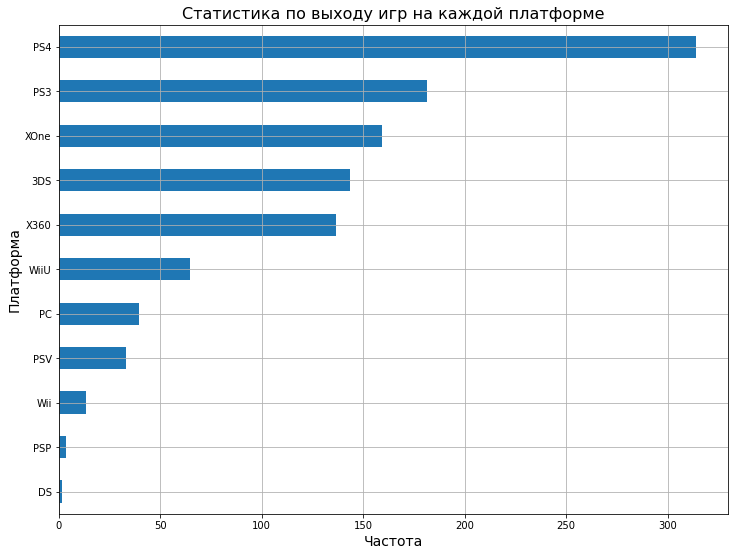

In [25]:
data.groupby(['platform'])['sales'].sum().sort_values(ascending = True).plot(kind = 'barh', figsize = (12,9), grid = True, width = 0.5)
plt.title('Статистика по выходу игр на каждой платформе', fontsize = 16)
plt.ylabel('Платформа',fontsize = 14)
plt.xlabel('Частота',fontsize = 14)
plt.show()

#### Определение актуальности платформ
Рассмотрим тот же самый график, только за актуальный период и посмотрим что происходит с продажами платформ


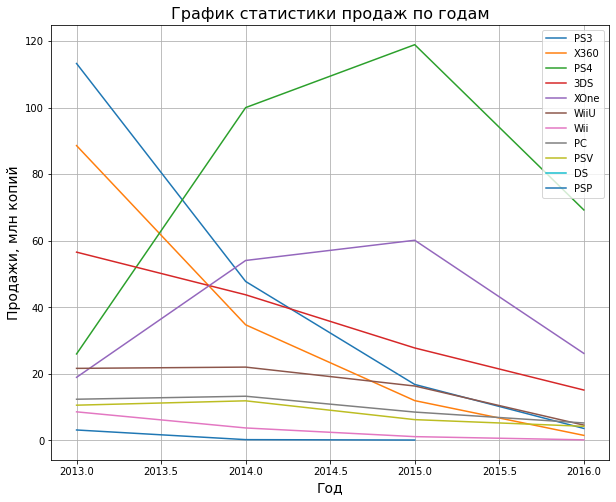

In [26]:
#возьмем все платформы, потому что мы не можем знать какие из них актуальны имеено в последние годы
platforms = data['platform'].unique()
fig, ay = plt.subplots(figsize = (10,8))

for platform in platforms:
    df = data[data['platform'] == platform].pivot_table(index = 'year_of_release',
                                                        values = 'sales',
                                                        aggfunc = 'sum')
    ay.plot(df.index, df['sales'], label = platform)
    
ay.grid(True)    
ay.legend()
plt.title('График статистики продаж по годам',fontsize = 16)
plt.xlabel('Год',fontsize = 14)
plt.ylabel('Продажи, млн копий',fontsize = 14)
plt.show()

**Можем сделать промежуточные выводы** <br/><br/>
Лидируют по продажам на данный момент **PS4**(c большим отрывом), **XOne** и **3DS**. Остальные платформы сконцентрировались около значений от 0 до 10 млн копий. <br/>
**PSP** вообще не продавалось в последний год.<br/><br/>

Если рассматривать топ 3 который мы вывели, из них за актуальность **3DS** только шла на спад(если сравнивать продажи за начало и конец периода. <br/>
У **PS4** и **XOne** тоже был спад за последний год, но это по сравнению с сильным скачком. Если сравнивать прожажи в настоящем времени и в начале рассматриваемого периода, то прибыль все равно выросла.<br/><br/>

Потенциально прибыльными считаю **PS4 и XOne**. Несмотря на спад, они являются самыми актуальными платформами на сегодняшний день, они популярны среди пользователей и превосходят в продажах другие платформы в несколько раз. <br/>
**3DS** потенциально прибыльной не считаю, количество проданных копий стабильно шли на спад весь актуальный период.

#### Построение ящика с усами

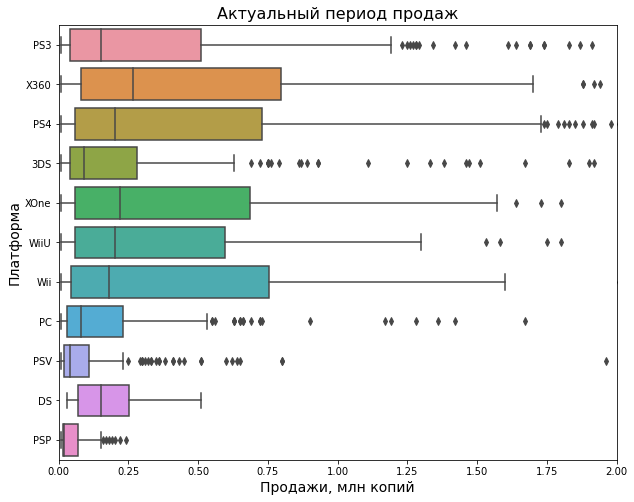

In [27]:
#построим диаграмму ящик с усами и проанализируем продажи
plt.figure(figsize = (10,8))

sns.boxplot(data = data, 
            y = 'platform',
            x = 'sales',
            orient = 'h')
plt.title('Актуальный период продаж',fontsize = 16)
plt.xlabel('Продажи, млн копий',fontsize = 14)
plt.ylabel('Платформа',fontsize = 14)
plt.xlim(0,2)
plt.show()


На данном графике мы видим распределение значений продажи копий игр по каждой из платформ. Можно заметить, что на 5 платформах межквартильное распределение почти одинаковое. А это значит что основная масса игр продавалась почти одинаково. <br/>
Предлагаю вывести график по 5 топовым платформам, чтобы рассмотреть их ближе

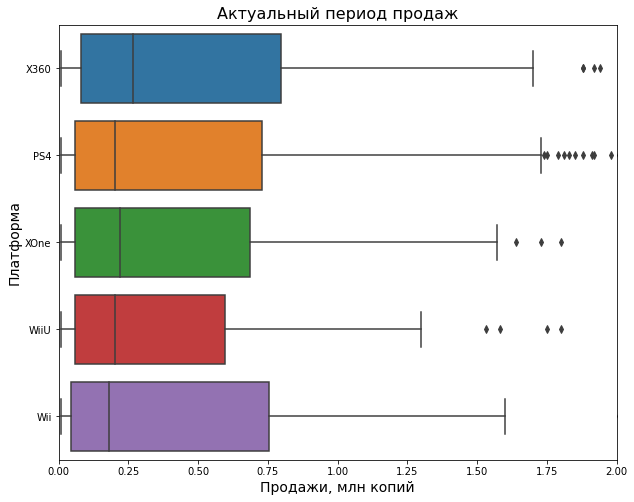

In [28]:
#сделаем срез с топ 5 платформами
df_act = data.query('platform in ["X360","PS4","XOne", "WiiU","Wii"]')
plt.figure(figsize = (10,8))

sns.boxplot(data = df_act, 
            y = 'platform',
            x = 'sales',
            orient = 'h')
plt.title('Актуальный период продаж',fontsize = 16)
plt.xlabel('Продажи, млн копий',fontsize = 14)
plt.ylabel('Платформа',fontsize = 14)
plt.xlim(0,2)
plt.show()


В результате мы получаем что есть топ 5 платформ, на которых очень схожая статистика по продажам игр. Но есть некоторые штучные выбросы, которые выбиваются за усы графика, и из-за этого как раз мы получаем большие значения на определенных платформах. Это значит что кака-то из платформ становится популярнее других буквально из-за нескольких игр. <br/><br/>
Если мы поближе рассмотрим графики двух самых популярных платформ: X360 и PS4, то заметим, что межквартильный размах у X360 даже больше, но в общем топе по продажам она находилась ниже. Это значит, что на X360 большее количество игр имеют популярность у пользователей, но есть единичные игры на PS4, которые очень хорошо продаются. Грубо говоря бестселлеров у PS4 больше, чем у X360.<br/>
Также, по этому графику на 3 месте стоит Wii, о которой мы раньше даже не слышали, хотя ее межквартильное распределение находится наравне с X360. У нее нет выбросов с большими значениями продаж, значит все продажи по играм распределены относительно равномерно. И в общем топе по продажам она никак не фигурировала. Следовательно, особо популярных игр у нее нет.

#### Расчет корреляции между отзывами и продажами
##### Продажи внутри платформы PS4

Коэффициент корреляции между отзывами критиков и продажами 0.4065679020617811
Коэффициент корреляции между отзывами пользователей и продажами -0.031957110204556376


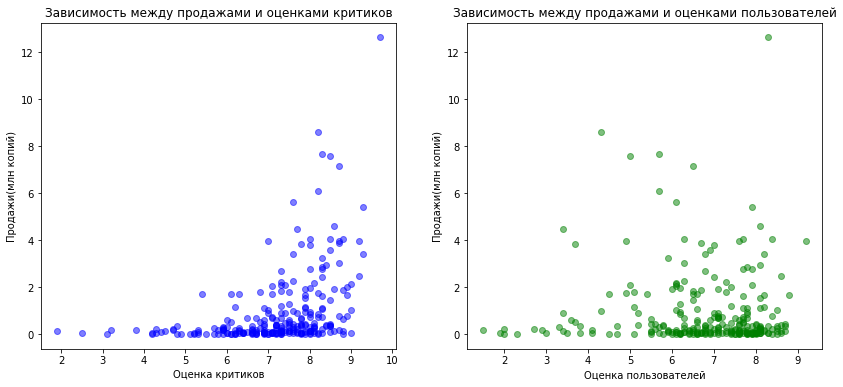

In [29]:
#получим значение корреляции между отзывами и продажами

#для начала сделаем срез с данными только по PS4
data_ps4 = data.query('platform == "PS4"')

fig,(ax_critic, ax_user) = plt.subplots(1,2, figsize = (14,6))

ax_critic.scatter(data_ps4['critic_score'], data_ps4['sales'], alpha = 0.5, color = 'blue')
ax_critic.set_title('Зависимость между продажами и оценками критиков')
ax_critic.set_xlabel('Оценка критиков')
ax_critic.set_ylabel('Продажи(млн копий)')

ax_user.scatter(data_ps4['user_score'], data_ps4['sales'], alpha = 0.5, color = 'green')
ax_user.set_title('Зависимость между продажами и оценками пользователей')
ax_user.set_xlabel('Оценка пользователей')
ax_user.set_ylabel('Продажи(млн копий)')

print('Коэффициент корреляции между отзывами критиков и продажами', data_ps4['critic_score'].corr(data_ps4['sales']))
print('Коэффициент корреляции между отзывами пользователей и продажами', data_ps4['user_score'].corr(data_ps4['sales']))


Мы получили графики зависимости продаж от оценок пользователей и критиков, а так же вывели коэффициенты корреляций для обоих случаев. <br/>
Выводы таковы, что между оценками критиков и продажами зависимость намного больше и коэффициент корреляции в данном случае составляет 0.4. А в случае с оценками пользователей он равен -0.03. Это значит, что между продажами и оценками пользователей зависимости почти нет. Да и по графику видно, что есть игры с низким рейтингом(3-4), а продажи все равно довольно высоки. <br/>
Если же посмотреть на график с оценками критиков, то там все более однозначно, низкая оценка = низкие продажи, и наоборот, но все равно не всегда, поэтому и коэффициент даже не 0.5, а меньше.

##### Продажи на других платформах
Чтобы проверить достоверность полученных выводов посмотрим как обстоят дела на других платформах. Для этого выведем графики для других 5 платформ.

In [30]:
import matplotlib.pyplot as plt

# Получаем уникальные значения платформ из столбца 'platform' и возьмем первые 5(не считая PS4)
platforms = data['platform'].unique()[0:6]
platforms

array(['PS3', 'X360', 'PS4', '3DS', 'XOne', 'WiiU'], dtype=object)

Коэффициенты корреляций для всех случаев:

Коэфф. корреляции прожажи-критики PS3 0.3342853393371917
Коэфф. корреляции прожажи-пользователи PS3 0.0023944027357566925 

Коэфф. корреляции прожажи-критики X360 0.35034454602286613
Коэфф. корреляции прожажи-пользователи X360 -0.011742185147181342 

Коэфф. корреляции прожажи-критики PS4 0.4065679020617811
Коэфф. корреляции прожажи-пользователи PS4 -0.031957110204556376 

Коэфф. корреляции прожажи-критики 3DS 0.3570566142288107
Коэфф. корреляции прожажи-пользователи 3DS 0.24150411773563016 

Коэфф. корреляции прожажи-критики XOne 0.4169983280084022
Коэфф. корреляции прожажи-пользователи XOne -0.06892505328279414 

Коэфф. корреляции прожажи-критики WiiU 0.37641490654239135
Коэфф. корреляции прожажи-пользователи WiiU 0.4193304819266187 



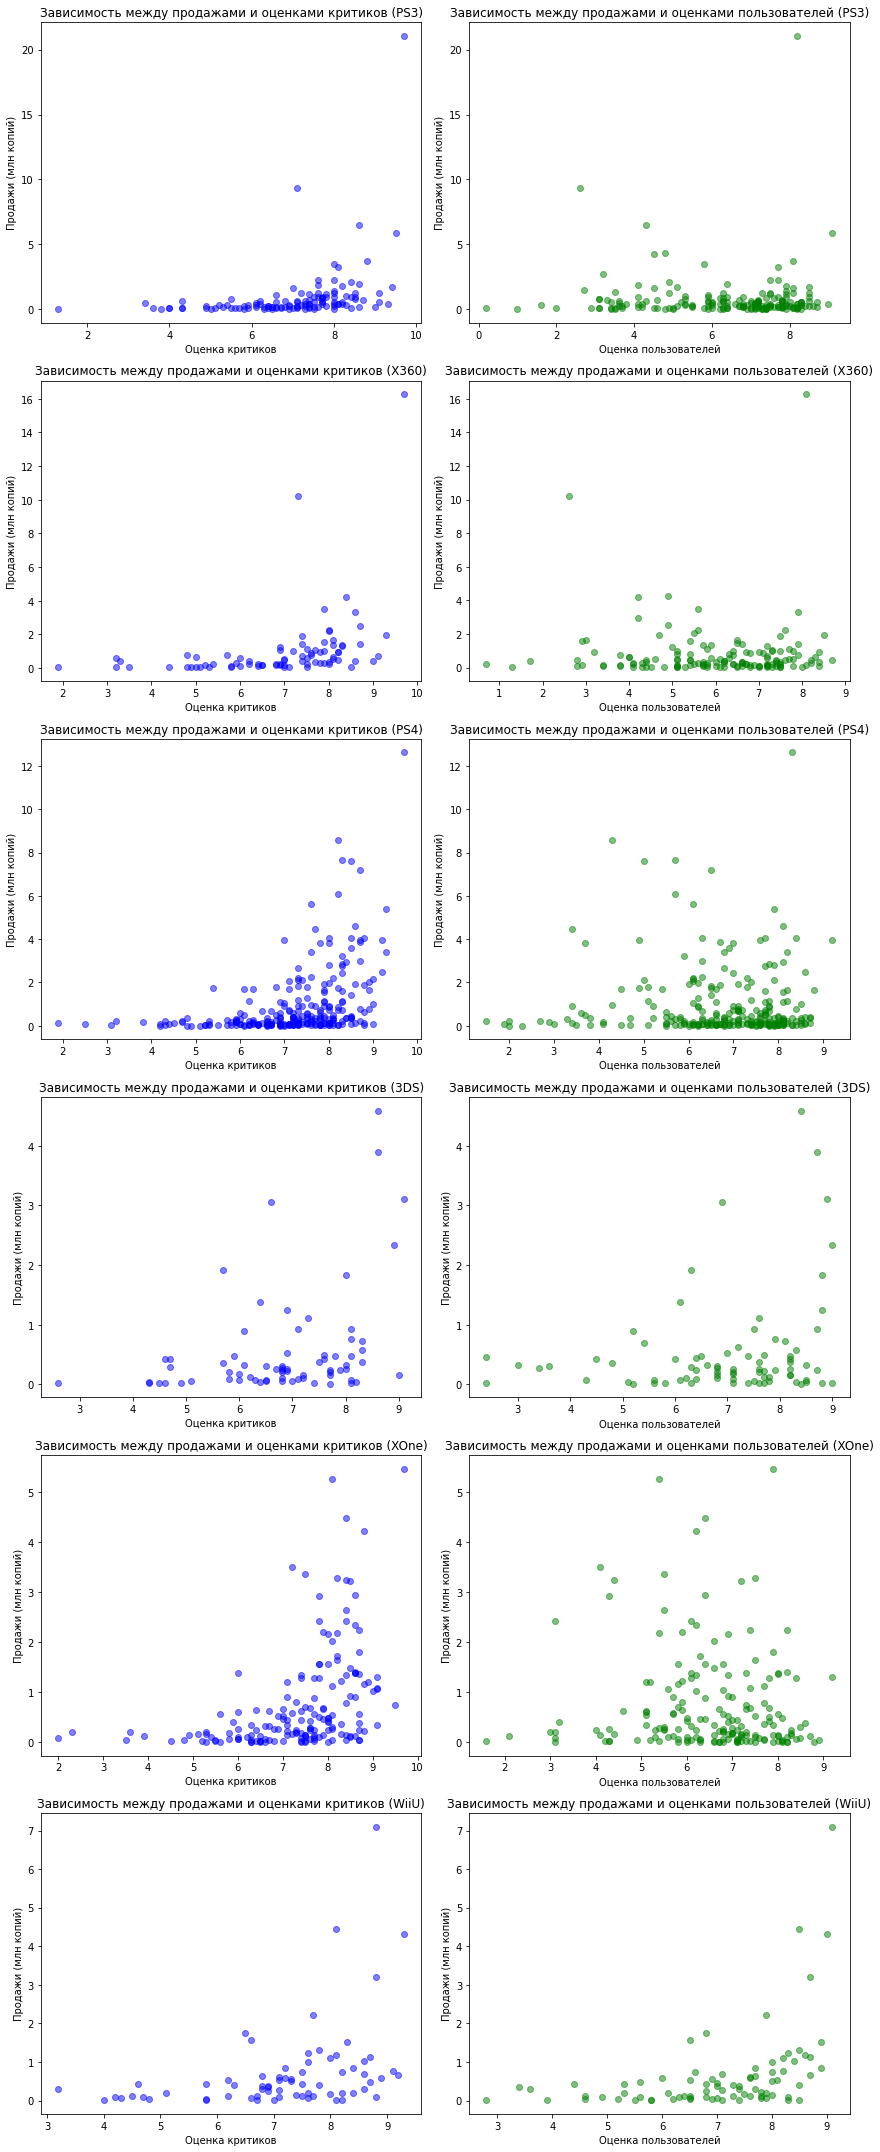

In [31]:
print('Коэффициенты корреляций для всех случаев:\n')
# Создаем фигуру с подграфиками
fig, axes = plt.subplots(len(platforms), 2, figsize=(12, 5*len(platforms)))

# Перебираем платформы и создаем графики
for i, platform in enumerate(platforms):
    data_platform = data.query(f'platform == "{platform}"')
    
    #print(data_platform.head())
    # График для оценок критиков
    axes[i, 0].scatter(data_platform['critic_score'], data_platform['sales'], alpha=0.5, color='blue')
    axes[i, 0].set_title(f'Зависимость между продажами и оценками критиков ({platform})')
    axes[i, 0].set_xlabel('Оценка критиков')
    axes[i, 0].set_ylabel('Продажи (млн копий)')
    print(f'Коэфф. корреляции прожажи-критики {platform}', data_platform['critic_score'].corr(data_platform['sales']))
    
    # График для оценок пользователей
    axes[i, 1].scatter(data_platform['user_score'], data_platform['sales'], alpha=0.5, color='green')
    axes[i, 1].set_title(f'Зависимость между продажами и оценками пользователей ({platform})')
    axes[i, 1].set_xlabel('Оценка пользователей')
    axes[i, 1].set_ylabel('Продажи (млн копий)')
    print(f'Коэфф. корреляции прожажи-пользователи {platform}',data_platform['user_score'].corr(data_platform['sales']),'\n')

# Размещаем графики так, чтобы они не перекрывали друг друга
plt.tight_layout()
plt.show()

Проанализировал все эти графики и коэффициенты корреляций мы можем сделать почти такие же выводы, что и в случае с самой популярной платформой.<br/>
**Вывод**: Между продажами и оценками критиков есть зависимость, не особо сильная, но есть. А между оценками пользователей и проданными копиями зависимости нет. Популярная игра не обязательно будет признана у пользователей, всегда найдутся те, кому она может не понравится. Критики же в своих выводах более однозначны. <br/>
Возможно, это связано с тем, что критиков намного меньше чем пользователей, да и всегда найдутся те, кто может поставить плохую оценку просто так, специально, ради шутки или же из личной неприязни. Критики оценивают более объективно.<br/>
Можно заметить, что на всех проверенных платформах коэффициент корреляции между оценками критиков и продажами находится около 0.4, а вот с коэффициентом между оценками пользователей и продажами не все так стабильно. На двух платформах - 3DS и Wii встретились значения 0.2 и 0.41. С чем это может быть связано я не знаю, но видимо на это влияют какие-то иные факторы, влияние которых мы не оценивали.

#### Расределение по жанрам
Самые прибыльные жанры <br/>
Самые продаваемые и непродаваемые жанры

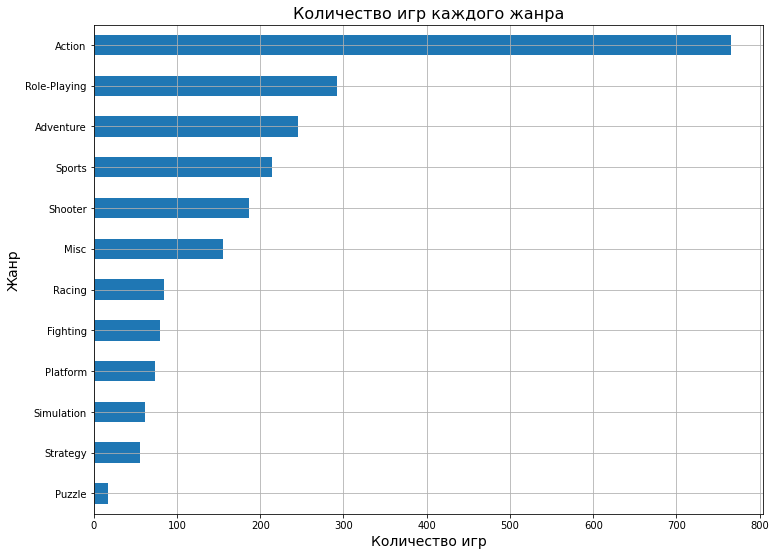

In [32]:
data.groupby('genre')['name'].count().sort_values(ascending = True).plot(kind = 'barh', figsize = (12,9), grid = True, width = 0.5)
plt.title('Количество игр каждого жанра',fontsize = 16)
plt.xlabel('Количество игр',fontsize = 14)
plt.ylabel('Жанр',fontsize = 14)
plt.show()

Очевидно, Action - самый популярный жанр, который очень сильно превосходит другие в количестве игр. А игр с жанром Puzzle - меньше всего. <br/><br/>
Найдем статистику по продажам игр каждого жанра
Чтобы узнать какой из жанров самый прибыльный, надо будет посчитать сколько в среднем приносит одна игра каждого из жанров. 

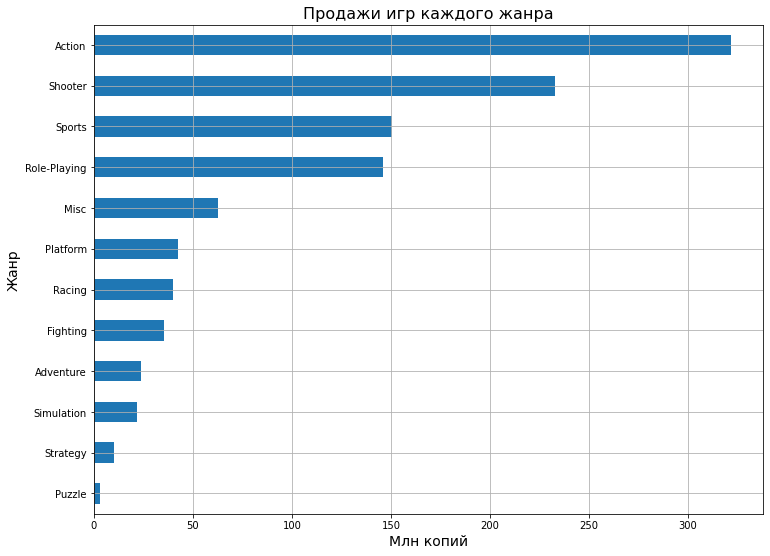

In [33]:
#статистика по продажам игр каждого жанра
data.groupby('genre')['sales'].sum().sort_values(ascending = True).plot(kind = 'barh', figsize = (12,9), grid = True, width = 0.5)
plt.title('Продажи игр каждого жанра',fontsize = 16)
plt.xlabel('Млн копий',fontsize = 14)
plt.ylabel('Жанр',fontsize = 14)
plt.show()

Такой график не особо информативен, так как очевидно, что чем больше игр в каком то жанре, тем больше в сумме будет продано млн копий этой игры, в сравнении с жанром, в котором очень мало игр. Для более объективной оценки посчитаем среднее значение для 1 игры в каждом жанре.

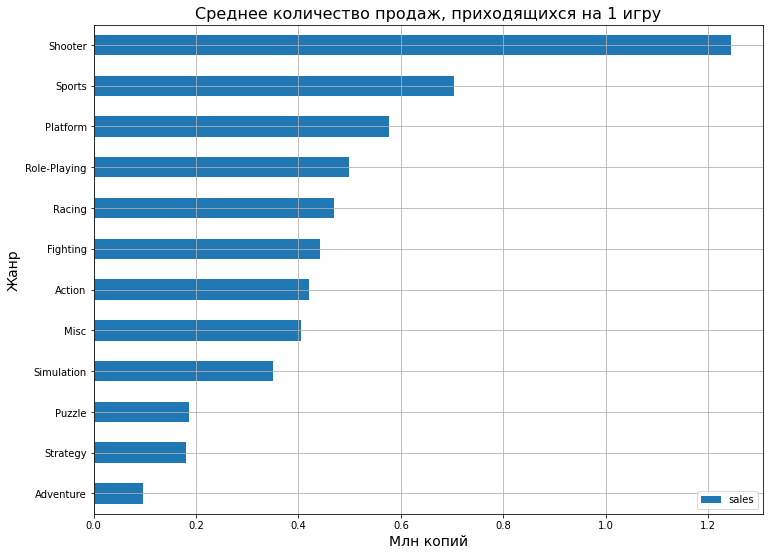

In [34]:
data.pivot_table(index = 'genre', values = 'sales', aggfunc = 'mean').sort_values(by = 'sales', ascending = True).plot(kind = 'barh', figsize = (12,9), grid = True, width = 0.5)
plt.title('Среднее количество продаж, приходящихся на 1 игру',fontsize = 16)
plt.xlabel('Млн копий',fontsize = 14)
plt.ylabel('Жанр',fontsize = 14)
plt.show()

Теперь другое дело. Как можно заметить, первое и последнее место теперь занимают другие жанры. <br/>
Самый продаваемый жанр - Shooter, он сильно выбивается среди остальных. А последнее место занимает Adventure, тоже с сильным отрывом.

### Шаг. Составление портрета пользователя каждого региона
#### Самые популярные платформы. Топ 5 для каждого региона(NA, EU, JP)

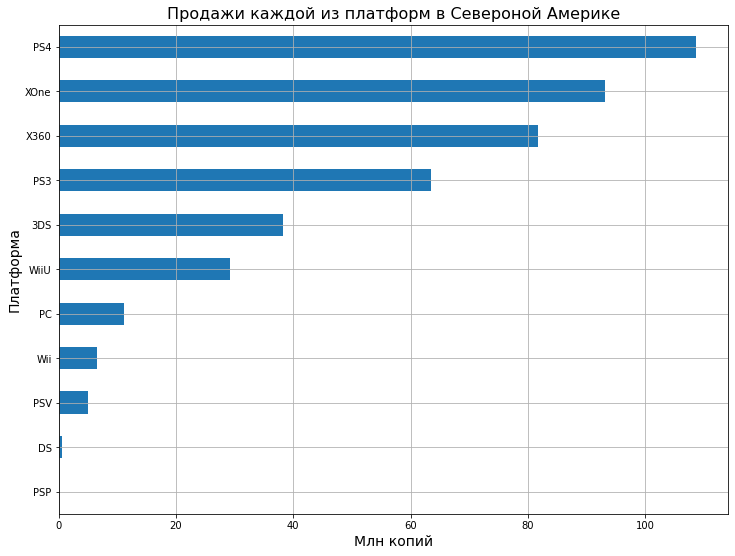

In [35]:
data.groupby('platform')['na_sales'].sum().sort_values(ascending = True).plot(kind = 'barh', figsize = (12,9), grid = True, width = 0.5)
plt.title('Продажи каждой из платформ в Североной Америке',fontsize = 16)
plt.xlabel('Млн копий',fontsize = 14)
plt.ylabel('Платформа',fontsize = 14)
plt.show()

На таком графике можно сразу ответить на вопрос про топ 5 платформ в регионе, но он не несет в себе информации о том, какая доля пользователей выбирает ту или иную платформу, поэтому построим круговую диаграмму с процентами

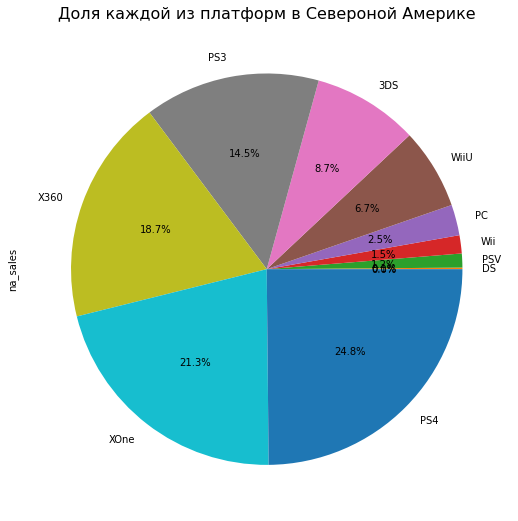

In [36]:
data.groupby('platform')['na_sales'].sum().sort_values().plot(kind = 'pie',figsize = (9,9), autopct='%1.1f%%')
plt.title('Доля каждой из платформ в Североной Америке',fontsize = 16)
plt.show()

Теперь мы можем видеть доли пользователей по платформам в процентном соотношении. Можем сделать выводы, что:
* четверть всех пользователей в Северной Америке пользуется PS4
* 21% выбирает XOne
* почти столько же, но меньше - 18.7% выбирают X360
* на рынке с небольшой разницей лидируют 3 эти платформы
<br/><br/> **ТОП 5** получаем:
1. PS4(24.8%)
2. XOne(21.3%)
3. X360(18.7%)
4. PS3(14.5%)
5. 3DS(8.7%)

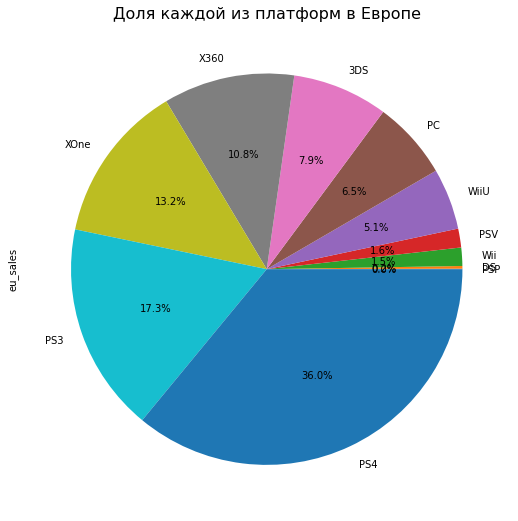

In [37]:
data.groupby('platform')['eu_sales'].sum().sort_values().plot(kind = 'pie',figsize = (9,9), autopct='%1.1f%%')
plt.title('Доля каждой из платформ в Европе',fontsize = 16)
plt.show()

В Европе дела обстоят иначе. Самая популярная платформа такая же, как и в Северной Америке, но доля пользователей составляет уже 36%. А никакая из оставшихся платформ не добирает даже 20%. Можно сказать что на рынке Европы есть безусловный лидер. <br/><br/>
**ТОП 5:**
1. PS4(36%)
2. PS3(17.3%)
3. Xone(13.2%)
4. X360(10.8%)
5. 3DS(7.9%)



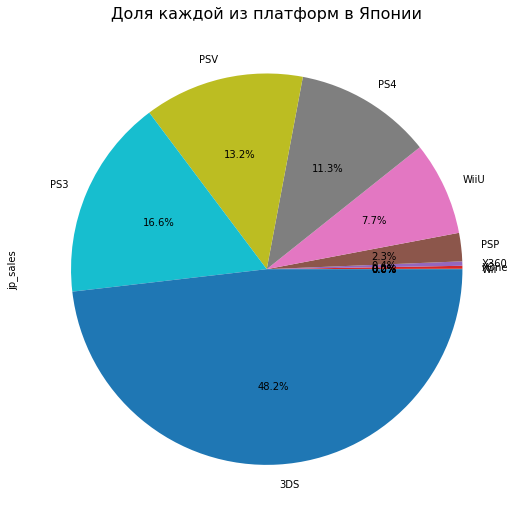

In [38]:
data.groupby('platform')['jp_sales'].sum().sort_values().plot(kind = 'pie',figsize = (9,9), autopct='%1.1f%%')
plt.title('Доля каждой из платформ в Японии',fontsize = 16)
plt.show()

В Японии неожиданно популярная в остальном мире PS4 занимает аж 4 место по популярности. И тут у нас уже есть абсолютный лидер рынка - платформа 3DS, которая является выбором почти половины пользователей. Все остальные платформы даже не дотягивают до 20% по отдельности. <br/><br/>
**ТОП 5:**
1. 3DS(48.2%)
2. PS3(16.6%)
3. PSV(13.2%)
4. PS4(11.3%)
5. WiiU(7.7%)

#### Самые популярные жанры в каждом регионе

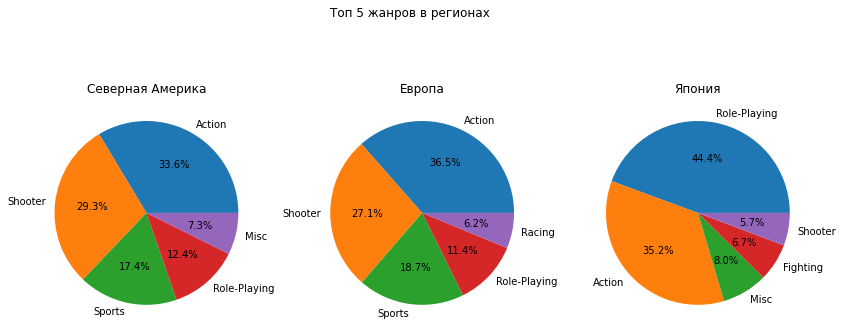

In [39]:
# Создаем фигуру и подграфики
fig, (na_plot, eu_plot, jp_plot) = plt.subplots(1, 3, figsize=(14, 6))

# Настройка заголовков для каждой диаграммы
na_plot.set_title('Северная Америка')
eu_plot.set_title('Европа')
jp_plot.set_title('Япония')

# Выводить будем только в соотношении к 5 самым популярным жанрам в регионе
sales_by_genres_na = data.groupby('genre')['na_sales'].sum().sort_values(ascending = False).head()
sales_by_genres_eu = data.groupby('genre')['eu_sales'].sum().sort_values(ascending = False).head()
sales_by_genres_jp = data.groupby('genre')['jp_sales'].sum().sort_values(ascending = False).head()

# Построение круговых диаграмм
na_plot.pie(sales_by_genres_na,labels = sales_by_genres_na.index, autopct='%1.1f%%')
eu_plot.pie(sales_by_genres_eu,labels = sales_by_genres_eu.index, autopct='%1.1f%%')
jp_plot.pie(sales_by_genres_jp,labels = sales_by_genres_jp.index, autopct='%1.1f%%')

# Показываем график
fig.suptitle('Топ 5 жанров в регионах')
plt.show()

Мы получили довольно наглядный график, описывающий топ 5 самых популярных жанров в каждом из регионов.<br/>
Проанализировав их можно сказать что, вкусы в Америке и Европе очень схожи. А в Японии сходства хоть и есть, но небольшие<br/><br/>
Если вынести общее у Европы и Северной Америки, то мы получим что треть всех продаж приходится на Action, далее почти 30% продаж приходится на Shooter, около 20% - Sports, далее около 12% - Role-Playing, а последние места в регионах делят Misc и Racing.<br/><br/>
Что же касается Японии, почти 45% приходится на Role-Playing, которое в остальных 2 регионах на 4 месте. Второе место, с тем же процентом что и в Америке и Европе занимает Action - 35%. Получается, если в остальных регионах проценты по жанрам распределялись относительно равномерно убывая, то в Японии сильно преобладает 2 жанра. На остальные 3 жанра в ТОП 5 самых популярных приходится от 8% до 6%, и это Misc, Fighting и Shooter. <br/><br/>
В целом, во всех трех регионах пользователи сильно любят жанр Action. Но в Америке и Европе почти так же любят Shooter, а в Японии не особо любят Shooter, но зато очень сильно любят Role-Playing.


#### Влияет ли рейтинг ESRB на продажи в каждом из регионов?

In [40]:
#проверим, какие уникальные значения оценок в столбце рейтинг встречаются
data['rating'].unique()

array(['M', nan, 'E', 'T', 'E10+'], dtype=object)

У нас есть 4 вида оценок и пропущенные значения. <br/><br/>
M - Mature - Взрослые (17+)<br/>
E10+ - Everyone 10 and older — "Для всех от 10 лет и старше"<br/>
T - Teen - Подростки (13+)<br/>
E - Everyone - все возрасты (0+)<br/>
<br/>
Решено заменить все пропущенные значения на "No Rating", возможно мы найдем там какую-нибудь закономерность.

In [41]:
data['rating'] = data['rating'].fillna('No Rating')
#проверим список уникальных значений сейчас
data['rating'].unique()

array(['M', 'No Rating', 'E', 'T', 'E10+'], dtype=object)

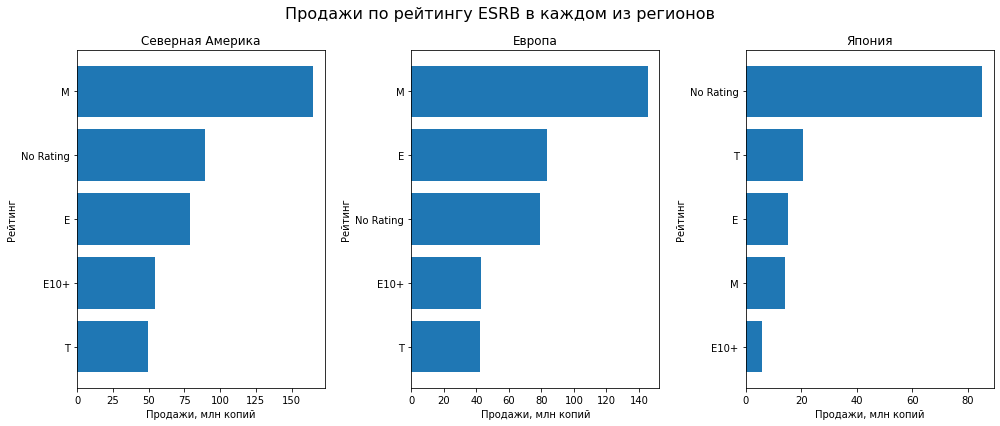

In [42]:
fig, (na_plot, eu_plot, jp_plot) = plt.subplots(1, 3, figsize=(14, 6))

# Настройка заголовков для каждой диаграммы
na_plot.set_title('Северная Америка')
eu_plot.set_title('Европа')
jp_plot.set_title('Япония')

# Выводить будем только в соотношении к 5 самым популярным жанрам в регионе
sales_by_rating_na = data.groupby('rating')['na_sales'].sum().sort_values(ascending = True)
sales_by_rating_eu = data.groupby('rating')['eu_sales'].sum().sort_values(ascending = True)
sales_by_rating_jp = data.groupby('rating')['jp_sales'].sum().sort_values(ascending = True)

# Построение столбчатых диаграмм
na_plot.barh(sales_by_rating_na.index, sales_by_rating_na)
na_plot.set_xlabel('Продажи, млн копий')
na_plot.set_ylabel('Рейтинг')
eu_plot.barh(sales_by_rating_eu.index, sales_by_rating_eu)
eu_plot.set_xlabel('Продажи, млн копий')
eu_plot.set_ylabel('Рейтинг')
jp_plot.barh(sales_by_rating_jp.index, sales_by_rating_jp)
jp_plot.set_xlabel('Продажи, млн копий')
jp_plot.set_ylabel('Рейтинг')

# Показываем график
fig.suptitle('Продажи по рейтингу ESRB в каждом из регионов', fontsize = 16)
plt.tight_layout()
plt.show()


Очень наглядно видно на графиках предподчтения пользователей в каждом из регионов по рейтингу. <br/>
Северная Америка и Европа снова очень похожи по привычкам, только 2 и 3 места поменялись местами. Но все равно там разница не сильно большая по долям, так что можно сказать, что поведение в этих двух регионах почти идентичны. Самый покупаемый рейтинг - игры 17+, для взрослых, а самый непокупаемый - 13+.<br/>
Эта статистика не стала исключением, в Японии дела обстоят совершенно иначе. Большая часть всех продаж приходится на игры Без рейтинга, все остальные категории продаются намного хуже, и хуже всего E10+ - игры для всех возрастов, от 10 лет.<br/><br/>

Почему такая странная статистика по Японии? Думаю ответ заключается в том, что огранизация ESRB, которая присваивает рейтинги играм - негосударственная, и работает преимущественно с США и Канадой. Думаю все дело в том, что большинство предпочитаемых игр в Японии - Японские, и эта организация просто не успела присвоить им рейтинг, либо же и вовсе не присвоит.

### Шаг. Проверка гипотез.
#### Одинаковые ли средние пользовательские рейтинги платформ Xbox One и PC?
Нулевая гипотеза в данном случае будет звучать так: рейтинги платформ Xbox One и PC равны между собой. <br/>
Альтернативная гипотеза: рейтинги платформ Xbox One и PC **не** равны между собой.<br/><br/>
Для проверки этой гипотезы мы будем применять метод ttest_ind, который проверяет равенство средних двух независимых переменных. Переменные независимы, так как выборки разного размера и связи друг с другом прямой не имеют.


In [43]:
#создадим отдельные переменные которые будут хранить в себе столбец с оценками пользователей по каждой из выбраных платформ
#а так же удалим пропуски
data_xone = data.loc[data['platform'] == 'XOne']['user_score'].dropna()
data_pc = data.loc[data['platform'] == 'PC']['user_score'].dropna()

#значение альфа возьмем 0.05 так как допустим легкую погрешность(менее строгое значение, в сравнении с 0.01)
alpha = 0.05

#в данном случае дисперсию примем разной, так как у нас нет оснований полагать что она одинаковая в обоих выборках
results = st.stats.ttest_ind(data_xone, data_pc, equal_var = False)

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


Мы получили p-значение больше альфа, а это значит, что отвергнуть нулевую гипотезу у нас не получится. Это значит, что мы принимаем H0 за достоверную. <br/><br/>
**Вывод:** Средние пользовательские рейтинги платформ Xbox One и PC равны между собой.

#### Средние пользовательские рейтинги жанров Action и Sports разные?
Нулевая гипотеза будет такая: Средние пользовательские рейтинги жанров Action и Sports равны между собой.<br/>
Альтернативная гипотеза:Средние пользовательские рейтинги жанров Action и Sports **не** равны между собой.<br/><br/>
В этом пункте будем идти по той же логике, что и в предыдущем.

In [44]:
#создадим отдельные переменные которые будут хранить в себе столбец с оценками пользователей по каждому из выбраных жанров
#и так же удалим пропуски
data_action = data.loc[data['genre'] == 'Action']['user_score'].dropna()
data_sports = data.loc[data['genre'] == 'Sports']['user_score'].dropna()

#значение альфа возьмем 0.05 так как допустим легкую погрешность(менее строгое значение, в сравнении с 0.01)
alpha = 0.05

#в данном случае дисперсию примем разной, так как у нас нет оснований полагать что она одинаковая в обоих выборках
results = st.stats.ttest_ind(data_action, data_sports, equal_var = False)

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


p-value получилось очень маленьким, во много раз меньше альфа. Это значит, H0 мы отвергаем. Получается, если отвергнута нулевая гипотеза, мы будем считать альтернативную - достоверной. <br/><br/>
**Вывод:** Средние пользовательские рейтинги жанров Action и Sports действительно разные.

### Вывод.
Мы исследовали полученный датафрейм с данными об играх за разные годы и можем сделать выводы о факторах, которые влияют на успешность игры среди пользователей. Также, мы можем составить портрет среднестатистического пользователя в основных регионах - Северная Америка, Европа и Япония.<br/><br/>

**Исходные данные**<br/><br/>

В полученных данных  было не так много пропусков в основных столбцах, но зато довольно много пропусков в столбцах с оценками. Малочисленные пропуски мы просто удалили, так как они составляли очень малую часть от всех данных и не смогли бы повлиять на результаты исследования, а пропуски в столбцах с оценками оставили. Где было нужно, делали выводы по тем данным, какие есть. Заполнить эти пропуски не представляется возможным. 

**Исследовательский анализ данных. Выводы.**<br/><br/>

-В датафрейме имеются данные с 1980 по 2016 год<br/>
-Пик выхода игр пришелся на период с 2007 до 2011 года<br/>
-В среднем цикл жизни платформы равен примерно 10 годам<br/>
-Актуальный период, на основе которого можно делать прогнозы на будущий год принят за данные последних 4 лет.<br/>
-Самые популярные платформы в мире - PS4(c большим отрывом), XOne и 3DS.<br/>
-Продажи имеют зависимость с оценками критиков, но совершенно никакой зависимости с оценками пользователей<br/>
-Action - самый популярный жанр, который очень сильно превосходит другие в количестве игр. А игр с жанром Puzzle - меньше всего.<br/>
-Самый продаваемый жанр - Shooter, он сильно выбивается среди остальных. А последнее место занимает Adventure.<br/><br/>

**Портрет среднестатистического пользователя каждого региона**<br/><br/>

*Пользователь из NA скорее всего предпочтет:*<br/>

-PS4 либо XOne<br/>
-Игры жанров Action или Shooter<br/>
-Игры с рейтингом 17+ (M)<br/>
<br/><br/>
*Пользователь из EU скорее всего предпочтет:*<br/>

-PS4<br/>
-Игры жанров Action или Shooter<br/>
-Игры с рейтингом 17+ (M)<br/><br/>

*Пользователь из JP скорее всего предпочтет:*<br/>

-3DS<br/>
-Игры жанров Role-Playing или Action<br/>
-Про рейтинг сказать сложно, большинство игр в Японии не оценены по шкале ESRB<br/><br/>

**Также были проверены пара гипотез, и найдены ответы на поставленные вопросы:**

1. Одинаковые ли средние пользовательские рейтинги платформ Xbox One и PC? <br/>
**Ответ**: Значения очень близки, поэтому гипотеза о том что средние пользовательские рейтинги одинаковы принимаем за достоверную. Да, одинаковые.<br/>

2. Средние пользовательские рейтинги жанров Action и Sports разные? <br/>
**Ответ**: Да, в ходе проведения t-теста было получено, что пользовательские рейтинги жанров Action и Sports действительно разные.

<br/><br/>
**Совет по поводу инвестиций рекламного бюджета:** прибыльнее всего будет вложиться в самые популярные платформы - PS4 и XOne, в разработку игр жанров Action, Shooter и Sports(если речь о Японском рынке, то предпочтительнее Role-Playing) с критериями для рейтинга M(17+). А так же важно, чтобы критики высоко оценили игру, тогда продажи будут выше.